In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### REPO: https://github.com/deri9377/masters/tree/main/Deep_Learning_week5

## The Problem

The objective of this mini project is to be able to create a painting generator. We will be using a dataset of paintings by monet and will be attmepting to create a art inspired by monet. We will be using a GAN to attempt this project. The project will be uploaded to kaggle which will calculate a score for us using FID. Which is a method that uses gaussian distrubutions to find the difference between the images.

## The Data

The data in this project consists of .jpg images held in two different folders. Monet_jpg and photo_jpg, The monet folder holds the training data or the true monet paintings that we will be using. This folder only contains about 300 files. The second folder, photo_jpg contains images of nature in the real world. This is going to be the images we will be sending through the GAN model and making look like monet paintings.

One of my concerns about this data is that there are not that many paintings to train on. 300 paintings is probably all there is but in ML I prefer to have more data than that. I found that while trainig the data was taking a long time to train with. Due to this I decided to downsize the images size. Also, I normalized the data around 0 from the 256, 256 coordinates.



In [7]:
dataset_monet = keras.utils.image_dataset_from_directory(
    "monet_jpg", label_mode=None, image_size=(256, 256), batch_size=1
).map(lambda x: (x - 127.5) / 127.5)
dataset_images = keras.utils.image_dataset_from_directory(
    "photo_jpg", label_mode=None, image_size=(256,256), batch_size=1
).map(lambda x: (x - 127.5) / 127.5)

Found 300 files.
Found 7038 files.


In [8]:
for x in dataset_monet.take(1):
    plt.axis("off")
    plt.imshow((x.numpy().astype(np.float32)/255).squeeze()[0])
    break
for x in dataset_images.take(1):
    plt.axis("off")
    plt.imshow((x.numpy().astype(np.float32)/255).squeeze()[0])
    break

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(layers.BatchNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    result.add(layers.BatchNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    # Downsampling layers
    down1 = downsample(64, 4, apply_batchnorm=False)(inputs)  # (128x128x64)
    down2 = downsample(128, 4)(down1)                         # (64x64x128)
    down3 = downsample(256, 4)(down2)                         # (32x32x256)
    down4 = downsample(512, 4)(down3)                         # (16x16x512)
    down5 = downsample(512, 4)(down4)                         # (8x8x512)
    down6 = downsample(512, 4)(down5)                         # (4x4x512)
    down7 = downsample(512, 4)(down6)                         # (2x2x512)
    down8 = downsample(512, 4)(down7)                         # (1x1x512)

    # Upsampling layers
    up1 = upsample(512, 4, apply_dropout=True)(down8)         # (2x2x512)
    up1 = layers.Concatenate()([up1, down7])
    
    up2 = upsample(512, 4, apply_dropout=True)(up1)           # (4x4x512)
    up2 = layers.Concatenate()([up2, down6])
    
    up3 = upsample(512, 4, apply_dropout=True)(up2)           # (8x8x512)
    up3 = layers.Concatenate()([up3, down5])
    
    up4 = upsample(512, 4)(up3)                               # (16x16x512)
    up4 = layers.Concatenate()([up4, down4])
    
    up5 = upsample(256, 4)(up4)                               # (32x32x256)
    up5 = layers.Concatenate()([up5, down3])
    
    up6 = upsample(128, 4)(up5)                               # (64x64x128)
    up6 = layers.Concatenate()([up6, down2])
    
    up7 = upsample(64, 4)(up6)                                # (128x128x64)
    up7 = layers.Concatenate()([up7, down1])
    
    # Final layer
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')           # (256x256x3)
    
    output = last(up7)

    return tf.keras.Model(inputs=inputs, outputs=output)

def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = downsample(64, 4, False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1,
                      kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs=inp, outputs=x)

### Architeture

For a GAN model you need to have a disriminator to determine your loss during training and a generator which will actually generate the images themselves. However, since this project is doing an image-to-image mapping we need to do things a bit differently. We are using a technique called CycleGAN. This allows the model to be able to turn images into paintings and paintings into images. Due to this we need to have two discriminators and two generators. During a training step we take in a real photo and painting and then compute fake versions of both. We then use our discriminators on these images to produce our loss and improve our models training. 


In [13]:
G = Generator()
F = Generator()

D_X = Discriminator()
D_Y = Discriminator()

In [23]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

LAMBDA = 10

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA * 0.5

In [24]:
g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Training

For training I decided to use 20 epochs with 50 steps. Originally I had 100 epochs but the training was too slow to be able to do that in time. The training is relatively simple as said before we just call the train_step function on each photo and painting combination.

In [25]:
@tf.function
def train_step(real_x, real_y):  # real_x: photos, real_y: Monet
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X → Y (photo → Monet)
        fake_y = G(real_x, training=True)
        cycled_x = F(fake_y, training=True)

        # Generator F translates Y → X (Monet → photo)
        fake_x = F(real_y, training=True)
        cycled_y = G(fake_x, training=True)

        # Same image identity loss
        same_x = F(real_x, training=True)
        same_y = G(real_y, training=True)

        # Discriminator output
        disc_real_x = D_X(real_x, training=True)
        disc_real_y = D_Y(real_y, training=True)
        disc_fake_x = D_X(fake_x, training=True)
        disc_fake_y = D_Y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        total_gen_g = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Backprop
    grads_g = tape.gradient(total_gen_g, G.trainable_variables)
    grads_f = tape.gradient(total_gen_f, F.trainable_variables)
    grads_dx = tape.gradient(disc_x_loss, D_X.trainable_variables)
    grads_dy = tape.gradient(disc_y_loss, D_Y.trainable_variables)

    g_optimizer.apply_gradients(zip(grads_g, G.trainable_variables))
    f_optimizer.apply_gradients(zip(grads_f, F.trainable_variables))
    d_x_optimizer.apply_gradients(zip(grads_dx, D_X.trainable_variables))
    d_y_optimizer.apply_gradients(zip(grads_dy, D_Y.trainable_variables))


In [29]:
import time

EPOCHS = 20
STEPS_PER_EPOCH = 50  # adjust based on your dataset size

photo_iter = iter(dataset_images.repeat())
monet_iter = iter(dataset_monet.repeat())

for epoch in range(EPOCHS):
    print(f'\n🌀 Starting epoch {epoch+1}/{EPOCHS}')
    start = time.time()

    for step in range(1, STEPS_PER_EPOCH + 1):
        real_x = next(photo_iter)
        real_y = next(monet_iter)
        train_step(real_x, real_y)

        if step % 10 == 0 or step == 1:
            print(f'  🔁 Step {step}/{STEPS_PER_EPOCH} completed')

    print(f'✅ Epoch {epoch+1} completed in {time.time() - start:.2f} sec')



🌀 Starting epoch 1/20
  🔁 Step 1/50 completed
  🔁 Step 10/50 completed
  🔁 Step 20/50 completed
  🔁 Step 30/50 completed
  🔁 Step 40/50 completed
  🔁 Step 50/50 completed
✅ Epoch 1 completed in 83.17 sec

🌀 Starting epoch 2/20
  🔁 Step 1/50 completed
  🔁 Step 10/50 completed
  🔁 Step 20/50 completed
  🔁 Step 30/50 completed
  🔁 Step 40/50 completed
  🔁 Step 50/50 completed
✅ Epoch 2 completed in 81.95 sec

🌀 Starting epoch 3/20
  🔁 Step 1/50 completed
  🔁 Step 10/50 completed
  🔁 Step 20/50 completed
  🔁 Step 30/50 completed
  🔁 Step 40/50 completed
  🔁 Step 50/50 completed
✅ Epoch 3 completed in 80.96 sec

🌀 Starting epoch 4/20
  🔁 Step 1/50 completed
  🔁 Step 10/50 completed
  🔁 Step 20/50 completed
  🔁 Step 30/50 completed
  🔁 Step 40/50 completed
  🔁 Step 50/50 completed
✅ Epoch 4 completed in 80.87 sec

🌀 Starting epoch 5/20
  🔁 Step 1/50 completed
  🔁 Step 10/50 completed
  🔁 Step 20/50 completed
  🔁 Step 30/50 completed
  🔁 Step 40/50 completed
  🔁 Step 50/50 completed
✅ Epoch 

In [32]:
from tensorflow.keras.utils import load_img, img_to_array
def load_and_preprocess_image(path):
    img = load_img(path, target_size=(256, 256))
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return tf.expand_dims(img, axis=0)  # Add batch dimension

In [33]:
photo = load_and_preprocess_image("photo_jpg/0a0c3a6d07.jpg")
monet_style = G(photo, training=False)

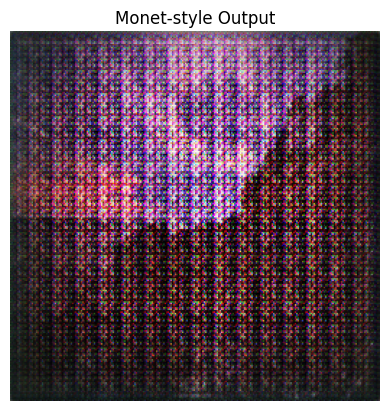

In [34]:
import matplotlib.pyplot as plt

def tensor_to_image(tensor):
    tensor = (tensor + 1) * 127.5
    tensor = tf.clip_by_value(tensor, 0, 255)
    return tf.cast(tensor[0], tf.uint8)

output_image = tensor_to_image(monet_style)

plt.imshow(output_image)
plt.axis('off')
plt.title("Monet-style Output")
plt.show()

In [36]:
import tensorflow as tf
import os
from PIL import Image
from tensorflow.keras.utils import load_img, img_to_array

# === CONFIG ===
input_folder = "photo_jpg"
output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

# === PREPROCESS FUNCTION ===
def load_and_preprocess_image(path):
    img = load_img(path, target_size=(256, 256))
    img = img_to_array(img)
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return tf.expand_dims(img, axis=0)

# === POSTPROCESS FUNCTION ===
def tensor_to_image(tensor):
    tensor = (tensor + 1.0) * 127.5  # [-1, 1] → [0, 255]
    tensor = tf.clip_by_value(tensor, 0, 255)
    return tf.cast(tensor[0], tf.uint8)

# === CONVERT LOOP WITH SINGLE LINE PROGRESS ===
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
total_images = len(image_files)

for idx, fname in enumerate(image_files, 1):
    input_path = os.path.join(input_folder, fname)
    output_path = os.path.join(output_folder, fname)

    photo = load_and_preprocess_image(input_path)
    monet_style = G(photo, training=False)
    image_array = tensor_to_image(monet_style).numpy()
    Image.fromarray(image_array).save(output_path)

    print(f"Converting image {idx}/{total_images}", end='\r')

print("\n✅ All images converted.")


Converting image 7038/7038
✅ All images converted.


## Results

Overall I think this did not work as well as I wanted it to. The GAN model works but it does not produce images that look monet like in style. The images are still recognizable compared to the orignal image but there are a lot of random red, green, and blue groupings all around the place. I have a feeling this is becuase I downsized the images in the generator and discriminator. Doing this likely causes groupings of similar colors when doing the generation. In the future I would like to run this model on a computer that has better resources or have more time since the original model would have taken days to run.

I also was unable to get the model to run in the competition.